# EDA on bad performing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Imports and Data Loading

In [ ]:
# Predicted validation data
file_val_predicted = './preprocessed/spellval_predicted.pkl'

# Train and validation data
file_train_val = './preprocessed/spelldata_train_val.pkl'

In [ ]:
import pandas as pd  # For csv and dataframe
import numpy as np  # For array
import pickle  # To save an load data
import matplotlib.pyplot as plt  # For plotting
import seaborn as sns  # For plotting
from nltk.tokenize import word_tokenize  # Tokenizing sentences
from textblob import TextBlob  # To get sentence length
import re  # Regular expression
from prettytable import PrettyTable  # To print in a table
from tqdm import tqdm  # To see progress bar
from collections import Counter  # To get counts of words

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [84]:
# Loading train data
train, _ = pickle.load(open(file_train_val, "rb"))

In [ ]:
# Loading predicted validation data
data = pickle.load(open(file_val_predicted, "rb"))

In [ ]:
def partition(x):
    " Dividing dataset into categories based on BLRU score "
    if x <= 0.35:
        return "bad"
    elif x <= 0.6:
        return "medium"
    else:
        return "good"

In [ ]:
data['grades'] = data['bleu_score'].map(partition)

In [ ]:
data.head()

,question,answer_inp,answer_out,Predictions,bleu_score,grades
360043,wow worst experience ever from orange county s...,<start> we are very sorry to hear that we coun...,we are very sorry to hear that we count on our...,we are sorry to hear this please do us your em...,0.199264,bad
730552,overall had a good time last night but our dri...,<start> i there can you please do us some deta...,i there can you please do us some detail about...,we are sorry to hear this was your experience ...,0.644672,good
196978,can i get a capable person to deal with your i...,<start> apologies for this sharon we are urgen...,apologies for this sharon we are urgently foll...,i would be happy to look into this for you ple...,0.652994,good
102306,main delay equip change chs gate agents did a ...,<start> that is fantastic to hear our agents a...,that is fantastic to hear our agents are the b...,we are so glad you enjoyed your flight we will...,0.335254,bad
828940,shout out to for ruining my experience watchin...,<start> i would be happy to help you with any ...,i would be happy to help you with any speed is...,i am sorry for the poor experience can you ple...,0.707107,good


In [ ]:
data['grades'].value_counts()

bad       76923
medium    50686
good      50240
Name: grades, dtype: int64

In [88]:
# Mask to get data of each cat.
mask_bad = (data['grades']=='bad')
mask_medium = (data['grades']=='medium')
mask_good = (data['grades']=='good')

## EDA

In [ ]:
# Utility function

#---------------------------------------------------------------
# Basic stats
#---------------------------------------------------------------
def basic_statistics (columns, data=data):
    """ Return basic statistics like min, max and others """
    x = PrettyTable()
    grades = data['grades'].unique().tolist()
    
    if len(columns)==1:
        header = columns + grades
    else:
        header = grades + columns

    result = {'minimum':[], 'maximum':[], 'mean':[], 'median':[], '25th per':[],
              '50th per':[], '75th per':[], '90th per':[], '95th per':[], '99th per':[]}

    for grade in grades:
        # data of each grade category
        data_grade = data[data['grades']==grade]
        for column in columns:
            col_val = data_grade[column].values
            # Getting stats
            result['minimum'].append(np.round(col_val.min(),2))
            result['maximum'].append(np.round(col_val.max(),2))
            result['mean'].append(np.round(np.mean(col_val),2))
            result['median'].append(np.round(np.median(col_val),2))
            for p in [25, 50, 75, 90, 95, 99]:
                result[str(p)+"th per"].append(np.round(np.percentile(col_val, p),2))
    
    # Printing results in a table
    x.field_names = header
    for tup in result.items():
        x.add_row([tup[0]]+tup[1])
    print(x)



#---------------------------------------------------------------
# Plotting Series
#---------------------------------------------------------------
def plot_func(columns, xlabel, ylabel, title, data=data):
    " Plots pdf and boxplot on the given data "
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(18, 6))
    
    # Adding subplots
    pdf = fig.add_subplot(1,2,1)
    box = fig.add_subplot(1,2,2)

    grades = data['grades'].unique().tolist()
    if len(columns) == 1:
        header = grades
    else:
        header = columns
    
    # pdf/distplot
    pdf.set(title=title, xlabel=xlabel, ylabel=ylabel)
    for i,grade in enumerate(grades):
        # data of each grade category
        data_grade = data[data['grades']==grade]
        for j,col in enumerate(columns):
            sns.distplot(data_grade[col].values, hist=True, rug=True, ax=pdf, label=header[i+j])
    pdf.legend()
    
    # boxplot
    box.set(title=title, ylabel=xlabel)
    if len(columns)==1:
        sns.boxplot(x='grades', y=columns[0], data=data, ax=box, orient='v')
    else:
        boxdata = []
        for grade in grades:
            data_grade = data[data['grades']==grade]
            for col in columns:
                boxdata.append(data[col])
        sns.boxplot(data=boxdata, ax=box, orient='v')
        box.set_xticklabels(header)
    
    plt.plot()

### BLEU score

In [ ]:
basic_statistics(['bleu_score'])

+------------+------+------+--------+
| bleu_score | bad  | good | medium |
+------------+------+------+--------+
|  minimum   | 0.0  | 0.6  |  0.35  |
|  maximum   | 0.35 | 1.0  |  0.6   |
|    mean    | 0.23 | 0.68 |  0.48  |
|   median   | 0.23 | 0.67 |  0.49  |
|  25th per  | 0.17 | 0.63 |  0.41  |
|  50th per  | 0.23 | 0.67 |  0.49  |
|  75th per  | 0.3  | 0.7  |  0.56  |
|  90th per  | 0.33 | 0.74 |  0.58  |
|  95th per  | 0.34 | 0.78 |  0.59  |
|  99th per  | 0.35 | 1.0  |  0.6   |
+------------+------+------+--------+


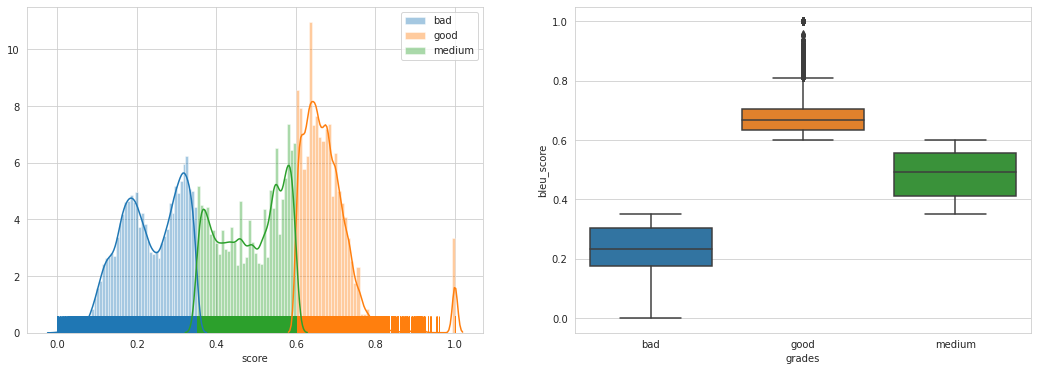

In [82]:
plot_func(['bleu_score'], "score", '', '')

1. We are dividing the data based on bleu score.
2. Score less than 0.35 is "bad" 0.35-0.6 is "medium" and anything greater is "good"
3. There are 76,000 bad datapoints and 50,000 each medium and good points
4. Can see lowest value 0 and highest value 1. There are very few points with bleu greater 0.75.
5. In "good" category most values are between 0.6 - 0.75

### Number of words

In [ ]:
data.rename(columns={"Predictions":"answer_pred"}, inplace=True)

In [ ]:
# Getting number of words for quesion, answer and prediction
data['qsn_len'] = data['question'].apply(lambda x: len(x.split()))
data['ans_len'] = data['answer_out'].apply(lambda x: len(x.split()))
data['pred_len'] = data['answer_pred'].apply(lambda x: len(x.split()))

+----------+-------+-------+--------+
| qsn_len  |  bad  |  good | medium |
+----------+-------+-------+--------+
| minimum  |   3   |   3   |   3    |
| maximum  |   39  |   39  |   39   |
|   mean   | 18.43 | 17.77 | 17.58  |
|  median  |  19.0 |  18.0 |  18.0  |
| 25th per |  13.0 |  12.0 |  12.0  |
| 50th per |  19.0 |  18.0 |  18.0  |
| 75th per |  23.0 |  23.0 |  23.0  |
| 90th per |  27.0 |  26.0 |  26.0  |
| 95th per |  32.0 |  30.0 |  30.0  |
| 99th per |  38.0 |  37.0 |  37.0  |
+----------+-------+-------+--------+


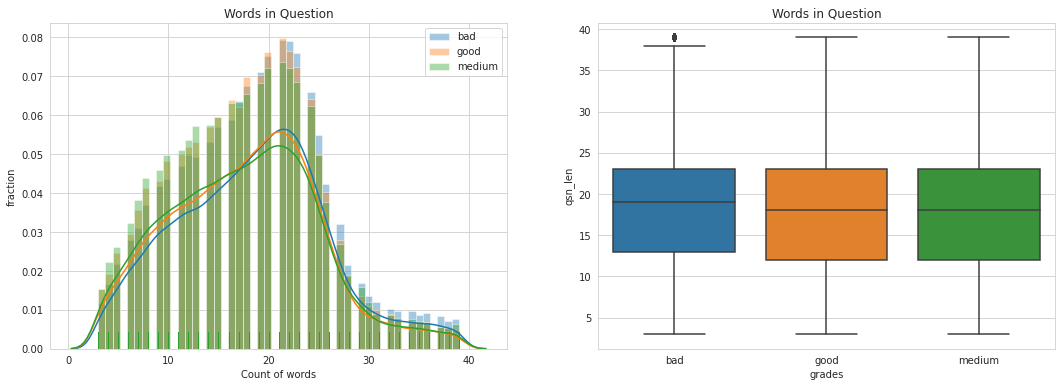

In [ ]:
# Number of words in Questions

basic_statistics(['qsn_len'])
plot_func(['qsn_len'], 'Count of words', 'fraction', 'Words in Question')

#### Observations for words in Questions:
1. There are not much difference in the stats or plots.
2. All the categories are having mean value close to 18.
3. All categories are overlapping, so not much we can say from no of words in questions.

+----------+-------+------+--------+
| ans_len  |  bad  | good | medium |
+----------+-------+------+--------+
| minimum  |   2   |  2   |   2    |
| maximum  |   38  |  38  |   38   |
|   mean   | 22.11 | 18.3 | 18.16  |
|  median  |  22.0 | 19.0 |  19.0  |
| 25th per |  18.0 | 15.0 |  13.0  |
| 50th per |  22.0 | 19.0 |  19.0  |
| 75th per |  26.0 | 22.0 |  23.0  |
| 90th per |  29.0 | 25.0 |  27.0  |
| 95th per |  33.0 | 26.0 |  29.0  |
| 99th per |  37.0 | 30.0 |  35.0  |
+----------+-------+------+--------+


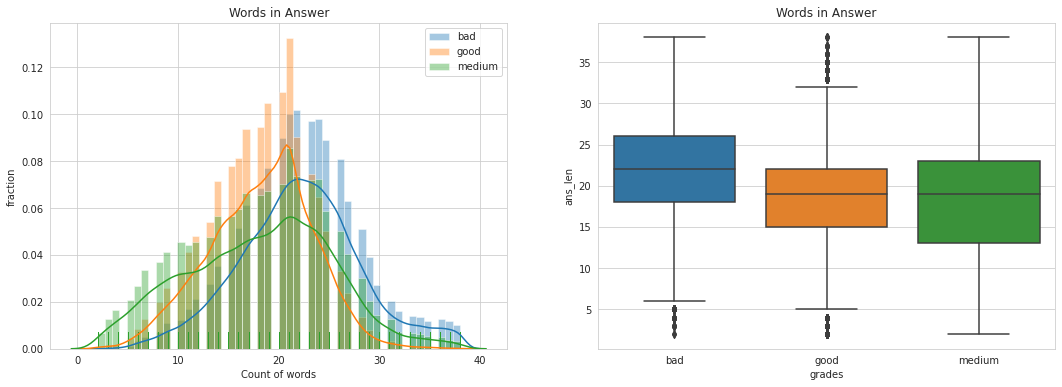

In [ ]:
# Number of words in Answers

basic_statistics(['ans_len'])
plot_func(['ans_len'], 'Count of words', 'fraction', 'Words in Answer')

#### Observations for words in Answers:
1. "bad" datapoints are having lots of words in them. Mean value is 22 that higher 4 more than good and medium.
2. "good" data has smaller IQR 15 - 22, with mean value 18 words in a sentence. Also it is visible the this category has least no of words in it than any other category.
3. "medium" data have lots of spread. With wider IQR but similar mean value as "good"
4. As the no of words in answer increases it is having poor bleu score.
5. Getting best scores for sentences with words 15 - 22 when look into the pdf.

+----------+-------+-------+--------+
| pred_len |  bad  |  good | medium |
+----------+-------+-------+--------+
| minimum  |   2   |   2   |   2    |
| maximum  |   39  |   39  |   39   |
|   mean   | 22.14 | 22.79 | 21.08  |
|  median  |  23.0 |  23.0 |  21.0  |
| 25th per |  18.0 |  20.0 |  17.0  |
| 50th per |  23.0 |  23.0 |  21.0  |
| 75th per |  26.0 |  26.0 |  25.0  |
| 90th per |  30.0 |  29.0 |  29.0  |
| 95th per |  33.0 |  31.0 |  31.0  |
| 99th per |  36.0 |  35.0 |  35.0  |
+----------+-------+-------+--------+


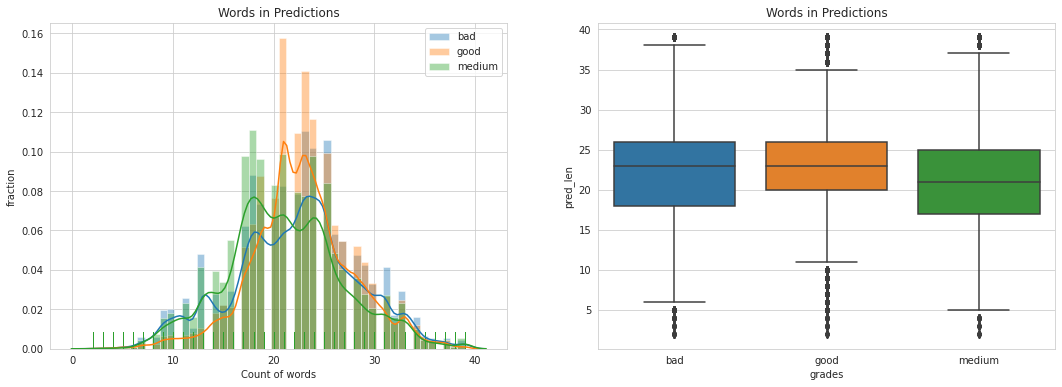

In [ ]:
# Number of words in Predictions

basic_statistics(['pred_len'])
plot_func(['pred_len'], 'Count of words', 'fraction', 'Words in Predictions')

#### Observations for words in Predictions:
1. Predictions are having higher no of words in them than questions.
2. "bad" category data have 22 words on average, and most of its values lie between 10-25 words.
3. "good" data have highest mean value among 3. But has narrower IQR 20 - 26. That means it is performing well only for a small no of points.
4. "medium" datapoints are having lowest no of words in them. IQR is evenly distributed from 25th to 75th percentile values.
5. When no of words are less model gives "medium" bleu score and for words 20-30 it performs best and after that it is giving "bad" bleu scores

In [ ]:
# Basic statistics
# Number of words in Each grade categories

basic_statistics(['qsn_len', 'asn_len', 'pred_len'], data=data[data['grades']=='bad'])
basic_statistics(['qsn_len', 'asn_len', 'pred_len'], data=data[data['grades']=='medium'])
basic_statistics(['qsn_len', 'asn_len', 'pred_len'], data=data[data['grades']=='good'])

+----------+---------+---------+----------+
|   bad    | qsn_len | asn_len | pred_len |
+----------+---------+---------+----------+
| minimum  |    3    |    2    |    2     |
| maximum  |    39   |    38   |    39    |
|   mean   |  18.43  |  22.11  |  22.14   |
|  median  |   19.0  |   22.0  |   23.0   |
| 25th per |   13.0  |   18.0  |   18.0   |
| 50th per |   19.0  |   22.0  |   23.0   |
| 75th per |   23.0  |   26.0  |   26.0   |
| 90th per |   27.0  |   29.0  |   30.0   |
| 95th per |   32.0  |   33.0  |   33.0   |
| 99th per |   38.0  |   37.0  |   36.0   |
+----------+---------+---------+----------+
+----------+---------+---------+----------+
|  medium  | qsn_len | asn_len | pred_len |
+----------+---------+---------+----------+
| minimum  |    3    |    2    |    2     |
| maximum  |    39   |    38   |    39    |
|   mean   |  17.58  |  18.16  |  21.08   |
|  median  |   18.0  |   19.0  |   21.0   |
| 25th per |   12.0  |   13.0  |   17.0   |
| 50th per |   18.0  |   19.0  |

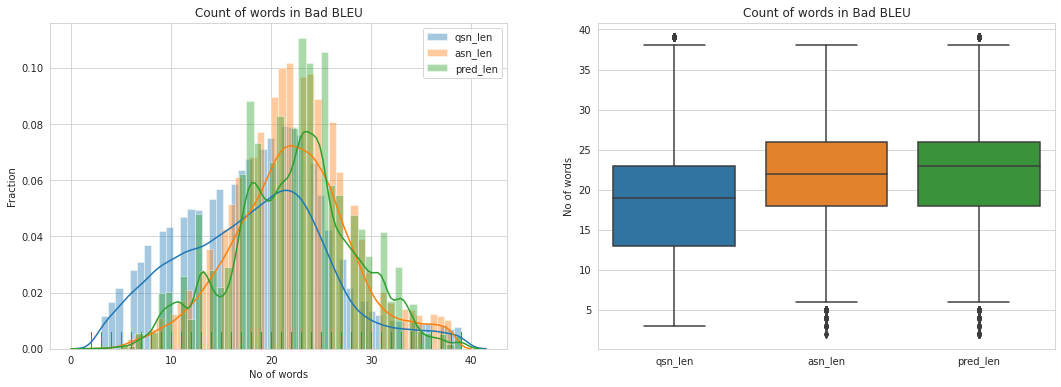

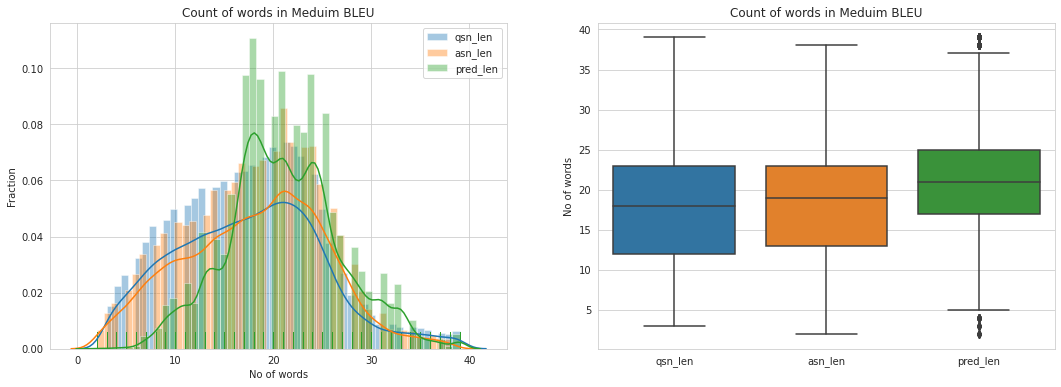

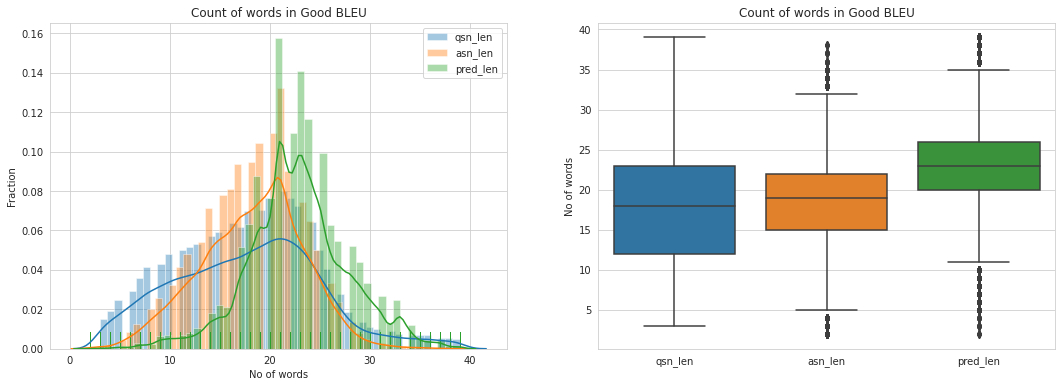

In [ ]:
# Plots: pdf and boxplot for each grade category

plot_func(['qsn_len', 'asn_len', 'pred_len'], 'No of words','Fraction','Count of words in Bad BLEU', data=data[data['grades']=='bad'])
plot_func(['qsn_len', 'asn_len', 'pred_len'], 'No of words','Fraction','Count of words in Meduim BLEU', data=data[data['grades']=='medium'])
plot_func(['qsn_len', 'asn_len', 'pred_len'], 'No of words','Fraction','Count of words in Good BLEU', data=data[data['grades']=='good'])

#### Observation on Entire data for no of words:
1. Let's look at total number of words present in data.
2. On average there are 18 words in question and around 22 words in prediction.
3. But Answer is having 18 words on average for "good" and "medium" data and 22 words in "bad" data.
4. Grades don't differ much for words in questions and preditions, but it is certainly changing for words in answers.
5. Model is performing best for lower no of words in answers. As the o of words increases its performance is becoming "bad". ALso it is giving good result for words in predictions higher than 20.

### Number of common words

In [ ]:
def no_common_words(col1, col2, data):
    " Number of common words in both the columns "
    len_common = []
    
    for ind, row in data.iterrows():
        qsn_set = set(row[col1].split())
        ans_set = set(row[col2].split()) 
        # common words in both of the features
        common_words = qsn_set.intersection(ans_set)
        len_common.append(len(common_words))

    return len_common

In [ ]:
# Common words in question and answers
data['qsn_ans_common'] = no_common_words('question', 'answer_out', data=data)

# Common words in questions and predictions
data['qsn_pred_common'] = no_common_words('question', 'answer_pred', data=data)

+----------------+------+------+--------+
| qsn_ans_common | bad  | good | medium |
+----------------+------+------+--------+
|    minimum     |  0   |  0   |   0    |
|    maximum     |  15  |  13  |   13   |
|      mean      | 2.41 | 2.03 |  1.99  |
|     median     | 2.0  | 2.0  |  2.0   |
|    25th per    | 1.0  | 1.0  |  1.0   |
|    50th per    | 2.0  | 2.0  |  2.0   |
|    75th per    | 3.0  | 3.0  |  3.0   |
|    90th per    | 5.0  | 4.0  |  4.0   |
|    95th per    | 6.0  | 5.0  |  5.0   |
|    99th per    | 8.0  | 7.0  |  7.0   |
+----------------+------+------+--------+


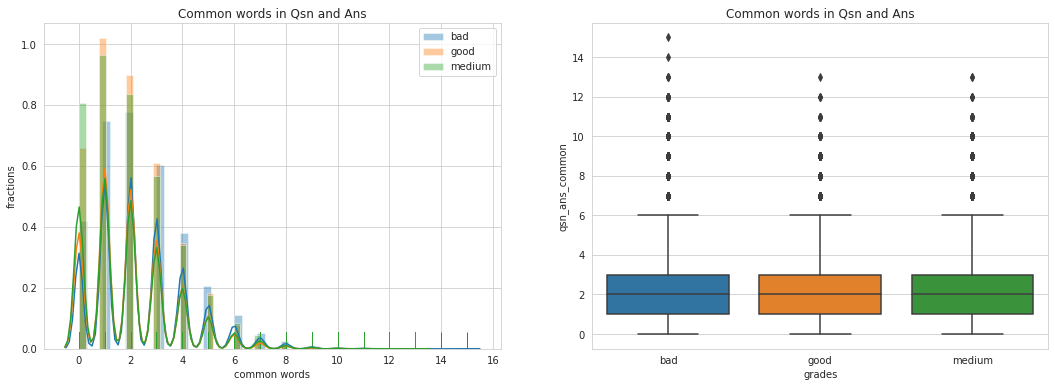

In [ ]:
# Common words in Question and Answer

basic_statistics(['qsn_ans_common'])
plot_func(['qsn_ans_common'], "common words", "fractions", "Common words in Qsn and Ans")

#### Observations for common words in Qsn and Ans:
1. The first thing we can notice here that there are not much common words in question ans answers. On average data have 2 words present in both question and answer for a sentence.
2. Maximum no of common word is 15 in "bad" data and 13 in others
3. There are not much difference in stats but can notice if no of common words increases in question and answer then model performance is going down.

+-----------------+------+------+--------+
| qsn_pred_common | bad  | good | medium |
+-----------------+------+------+--------+
|     minimum     |  0   |  0   |   0    |
|     maximum     |  11  |  11  |   11   |
|       mean      | 2.32 | 2.34 |  2.12  |
|      median     | 2.0  | 2.0  |  2.0   |
|     25th per    | 1.0  | 1.0  |  1.0   |
|     50th per    | 2.0  | 2.0  |  2.0   |
|     75th per    | 3.0  | 3.0  |  3.0   |
|     90th per    | 4.0  | 4.0  |  4.0   |
|     95th per    | 5.0  | 5.0  |  5.0   |
|     99th per    | 7.0  | 7.0  |  6.0   |
+-----------------+------+------+--------+


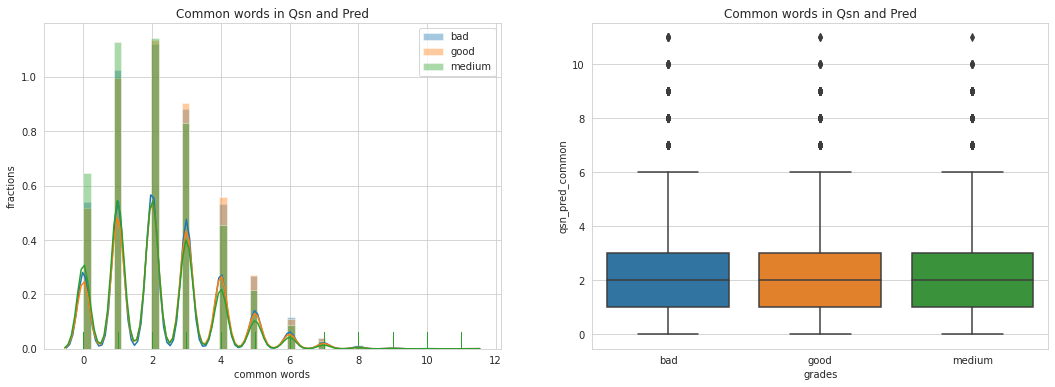

In [ ]:
# Common words in Question and Prediction

basic_statistics(['qsn_pred_common'])
plot_func(['qsn_pred_common'], "common words", "fractions", "Common words in Qsn and Pred")

#### Observations for common words in Qsn and Pred:
1. Not much we can see from these plots. They are similar and overlapping.

In [ ]:
# Common words in each grade category

basic_statistics(['qsn_ans_common', 'qsn_pred_common'], data=data[data['grades']=='bad'])
basic_statistics(['qsn_ans_common', 'qsn_pred_common'], data=data[data['grades']=='medium'])
basic_statistics(['qsn_ans_common', 'qsn_pred_common'], data=data[data['grades']=='good'])

+----------+----------------+-----------------+
|   bad    | qsn_ans_common | qsn_pred_common |
+----------+----------------+-----------------+
| minimum  |       0        |        0        |
| maximum  |       15       |        11       |
|   mean   |      2.41      |       2.32      |
|  median  |      2.0       |       2.0       |
| 25th per |      1.0       |       1.0       |
| 50th per |      2.0       |       2.0       |
| 75th per |      3.0       |       3.0       |
| 90th per |      5.0       |       4.0       |
| 95th per |      6.0       |       5.0       |
| 99th per |      8.0       |       7.0       |
+----------+----------------+-----------------+
+----------+----------------+-----------------+
|  medium  | qsn_ans_common | qsn_pred_common |
+----------+----------------+-----------------+
| minimum  |       0        |        0        |
| maximum  |       13       |        11       |
|   mean   |      1.99      |       2.12      |
|  median  |      2.0       |       2.0 

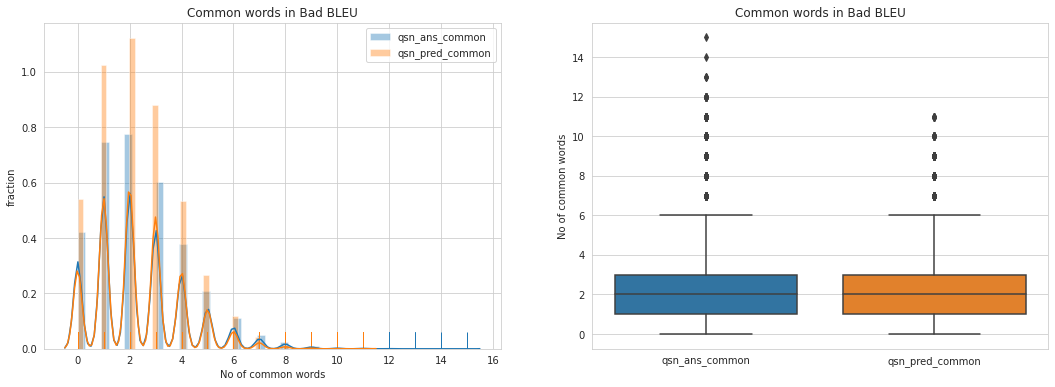

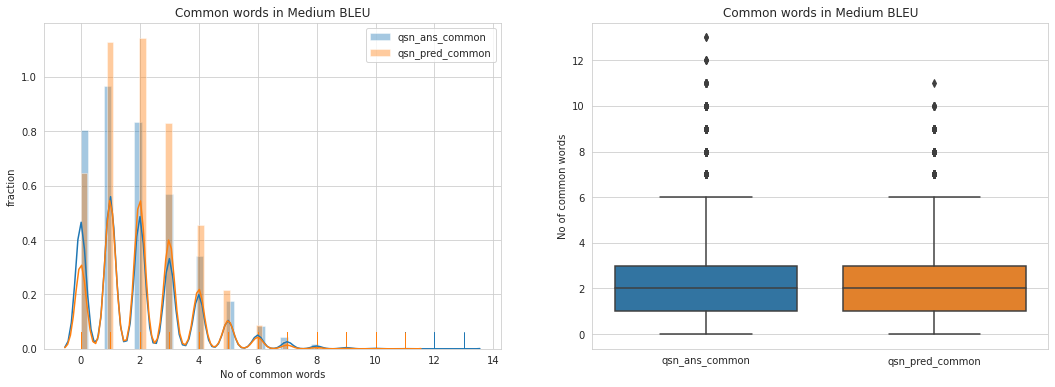

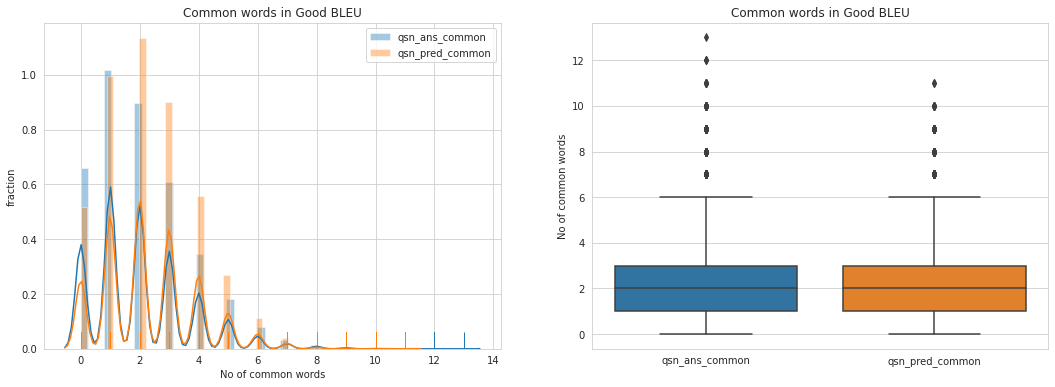

In [ ]:
# Common words in each grade category

plot_func(['qsn_ans_common', 'qsn_pred_common'], "No of common words", "fraction", "Common words in Bad BLEU", data=data[data['grades']=='bad'])
plot_func(['qsn_ans_common', 'qsn_pred_common'], "No of common words", "fraction", "Common words in Medium BLEU", data=data[data['grades']=='medium'])
plot_func(['qsn_ans_common', 'qsn_pred_common'], "No of common words", "fraction", "Common words in Good BLEU", data=data[data['grades']=='good'])

#### Observatons for common words in data:
1. Checking the number of common words between question-answer and question-prediction.
2. Looking into the plots or stats we can see that they are almost similar. Both the plots are overlapping.
3. Can observe that if no of common words in question and answer increases model's performance is becoming poor.
4. Also model is doing good for common words in question and prediction are between 2-4.

### Frequency of words

In [85]:
# Counting frequency of words in questions
qsn_cnt = Counter()
for text in train['question'].values:
    for word in text.split():
        qsn_cnt[word] += 1


# Frequency of words in answers
ans_cnt = Counter()
for text in train['answer_out'].values:
    for word in text.split():
        ans_cnt[word] += 1

In [90]:
def get_freq(column, data):
    " Frequency of words in validation data "
    freq_cnt = Counter()
    
    for sent in data[column].values:
        for word in sent.split():
            freq_cnt[word] += 1

    return dict(freq_cnt)

In [91]:
# Getting vocab words frequency for question, answer and prediction

# Word freq for bad data
bad_qsn_freq = get_freq('question', data=data[mask_bad])
bad_ans_freq = get_freq('answer_out', data=data[mask_bad])
bad_pred_freq = get_freq('answer_pred', data=data[mask_bad])

# Word freq for medium data
med_qsn_freq = get_freq('question', data=data[mask_medium])
med_ans_freq = get_freq('answer_out', data=data[mask_medium])
med_pred_freq = get_freq('answer_pred', data=data[mask_medium])

# Word freq for good data
good_qsn_freq = get_freq('question', data=data[mask_good])
good_ans_freq = get_freq('answer_out', data=data[mask_good])
good_pred_freq = get_freq('answer_pred', data=data[mask_good])

In [92]:
print("Bad BLEU: ", end='')
print(len(bad_qsn_freq), len(bad_ans_freq), len(bad_pred_freq))
print("Medium BLEU: ", end='')
print(len(med_qsn_freq), len(med_ans_freq), len(med_pred_freq))
print("Good BLEU: ", end='')
print(len(good_qsn_freq), len(good_ans_freq), len(good_pred_freq))

Bad BLEU: 23704 13486 1985
Medium BLEU: 21391 13290 2037
Good BLEU: 20470 11755 1876


#### Observations:
1. bad data have more no of words in its vocab than any other for question, answer and predictions.
2. Model is not doing good as vocab size increases.
3. We can see that model is missing huge no of words from answer vocab while predicting.
4. It is only predicting 15% of words from output vocab.

In [115]:
# Creating 3 dataframe for question, answer and predictions
df_qsn = pd.DataFrame(columns=['frequency', 'grades'])
df_ans = pd.DataFrame(columns=['frequency', 'grades'])
df_pred = pd.DataFrame(columns=['frequency', 'grades'])

In [116]:
# Adding data to above question dataframes
temp1 = pd.DataFrame({'frequency':list(bad_qsn_freq.values()), 'grades':'bad'})
temp2 = pd.DataFrame({'frequency':list(med_qsn_freq.values()), 'grades':'medium'})
temp3 = pd.DataFrame({'frequency':list(good_qsn_freq.values()), 'grades':'good'})

df_qsn = pd.concat([df_qsn, temp1, temp2, temp3], ignore_index=True)
df_qsn.shape

(65565, 2)

In [117]:
# Adding data to above answer dataframes
temp1 = pd.DataFrame({'frequency':list(bad_ans_freq.values()), 'grades':'bad'})
temp2 = pd.DataFrame({'frequency':list(med_ans_freq.values()), 'grades':'medium'})
temp3 = pd.DataFrame({'frequency':list(good_ans_freq.values()), 'grades':'good'})

df_ans = pd.concat([df_ans, temp1, temp2, temp3], ignore_index=True)
df_ans.shape

(38531, 2)

In [118]:
# Adding data to above prediction dataframes
temp1 = pd.DataFrame({'frequency':list(bad_pred_freq.values()), 'grades':'bad'})
temp2 = pd.DataFrame({'frequency':list(med_pred_freq.values()), 'grades':'medium'})
temp3 = pd.DataFrame({'frequency':list(good_pred_freq.values()), 'grades':'good'})

df_pred = pd.concat([df_pred, temp1, temp2, temp3], ignore_index=True)
df_pred.shape

(5898, 2)

+-----------+--------+--------+-------+
| frequency |  bad   | medium |  good |
+-----------+--------+--------+-------+
|  minimum  |   1    |   1    |   1   |
|  maximum  | 49805  | 32185  | 33683 |
|    mean   | 59.82  | 41.65  |  43.6 |
|   median  |  2.0   |  2.0   |  2.0  |
|  25th per |  1.0   |  1.0   |  1.0  |
|  50th per |  2.0   |  2.0   |  2.0  |
|  75th per |  9.0   |  8.0   |  8.0  |
|  90th per |  43.0  |  34.0  |  35.0 |
|  95th per | 121.0  |  90.0  |  93.0 |
|  99th per | 839.97 | 552.2  | 597.0 |
+-----------+--------+--------+-------+


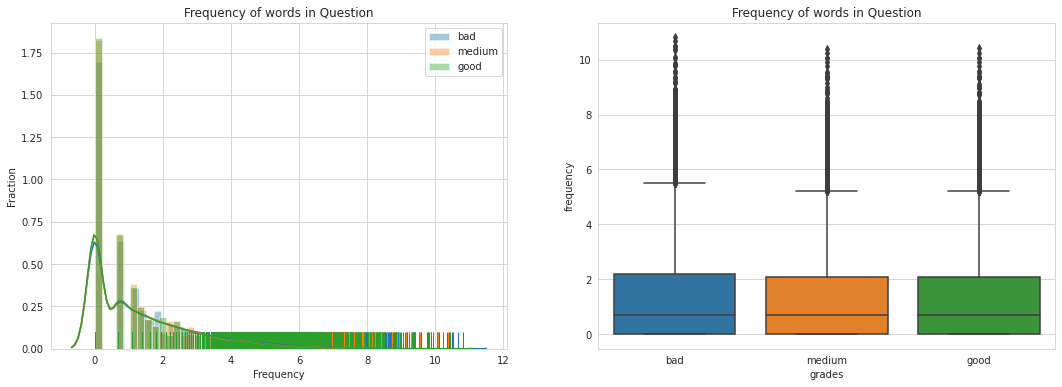

In [123]:
basic_statistics(['frequency'], data=df_qsn)

# Beacuse the range of the feature is very wide and most of the values are close to 0
# Applying log on the counts for better visualization
df_qsn['frequency'] = df_qsn['frequency'].map(np.log)
plot_func(['frequency'], 'Frequency', 'Fraction', 'Frequency of words in Question', data=df_qsn)

#### Observation on frequency of words in bad data:
1. We have more than 20,000 words in questions.
2. Total no of sentenece in data is 180,000
2. But 50% of the words are only occur 2 or less, that means more than 11,000 words are present 2 or less next 5000 words are there about 2-9 times. About 80% of the words are very rare in the huge corpus of data.
3. Also we can see that 1% of vocab are extremly frequent in the vocab.

+-----------+---------+--------+---------+
| frequency |   bad   | medium |   good  |
+-----------+---------+--------+---------+
|  minimum  |    1    |   1    |    1    |
|  maximum  |  76923  | 50686  |  50240  |
|    mean   |  126.1  | 69.26  |  78.22  |
|   median  |   3.0   |  3.0   |   3.0   |
|  25th per |   1.0   |  1.0   |   1.0   |
|  50th per |   3.0   |  3.0   |   3.0   |
|  75th per |   13.0  |  11.0  |   11.0  |
|  90th per |   61.0  |  46.0  |   50.0  |
|  95th per |  162.0  | 115.55 |  125.3  |
|  99th per | 1587.95 | 904.55 | 1120.92 |
+-----------+---------+--------+---------+


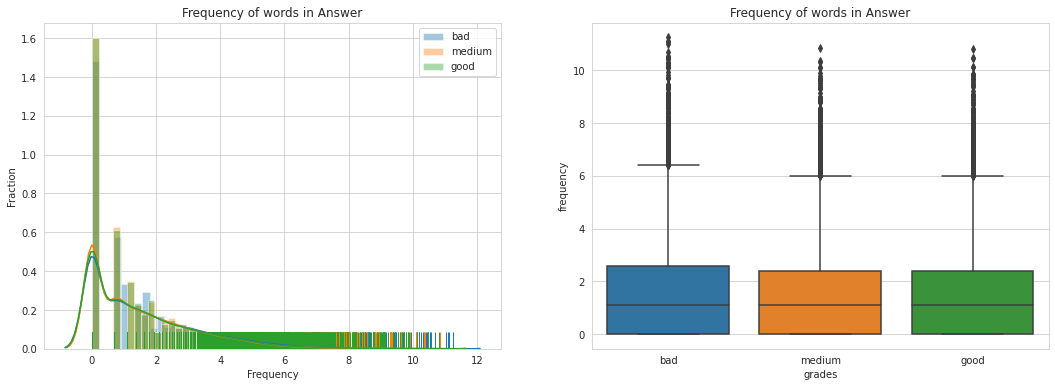

In [126]:
basic_statistics(['frequency'], data=df_ans)
df_ans['frequency'] = df_ans['frequency'].map(np.log)
plot_func(['frequency'], 'Frequency', 'Fraction', 'Frequency of words in Answer', data=df_ans)

#### Observation on word frequency in Answers:
1. There are 11,000+ words in answers for any category.
2. Words are more frequent than question
3. Here also 80% of the words in vocab are rare.
4. And then we can see that 5% of the vocab's words are frequent.
5. So because there are lot's of rare words in vocab and model is not able to learn much about rare words and missing 85% of the words from vocab, and then there are high frequent words which are controling model's performance.

+-----------+---------+----------+---------+
| frequency |   bad   |  medium  |   good  |
+-----------+---------+----------+---------+
|  minimum  |    1    |    1     |    1    |
|  maximum  |  92344  |  56072   |  58346  |
|    mean   |  857.88 |  524.46  |  610.37 |
|   median  |   10.0  |   9.0    |   9.0   |
|  25th per |   2.0   |   2.0    |   2.0   |
|  50th per |   10.0  |   9.0    |   9.0   |
|  75th per |   88.0  |   75.0   |   72.0  |
|  90th per |  539.8  |  412.8   |  506.5  |
|  95th per |  2252.4 |  1384.6  |  1646.5 |
|  99th per | 25276.0 | 14225.04 | 16621.5 |
+-----------+---------+----------+---------+


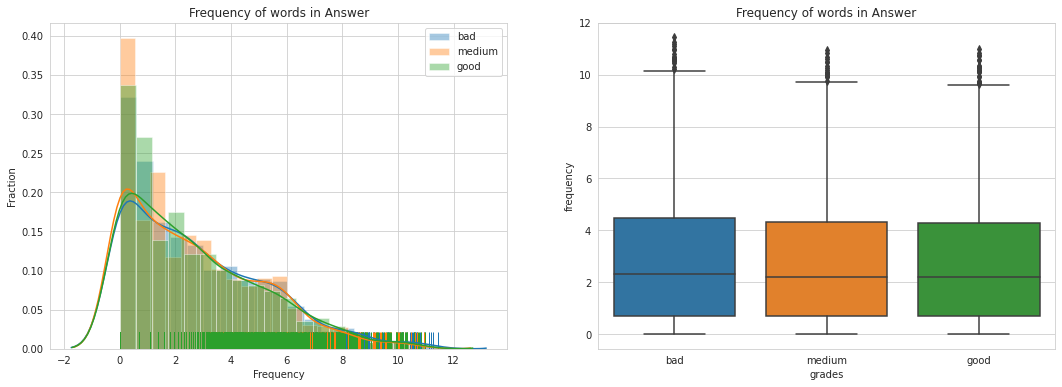

In [127]:
basic_statistics(['frequency'], data=df_pred)
df_pred['frequency'] = df_pred['frequency'].map(np.log)
plot_func(['frequency'], 'Frequency', 'Fraction', 'Frequency of words in Answer', data=df_pred)

#### Observation on Prediction's word frequency:
1. Predicted words are only have 1800+ unique words, that is only 15% of all possible words.
2. Can see words are lots more frequent.
3. So as the model is only predicting only a sample if words from entire possible words, so it is replacing those words that is 85% of the vocab words which are rare with words that are too frequent in answer vocab.
4. We have few words ocuuring 92,000+ times that is almost half of them sentences are having that words.
5. So to say it simply model is not able to learn rare words those are present very few times in training data. And during prediction it is just replacing those words with most frequent words.

### Number of words with very high frequency

In [128]:
len(qsn_cnt), len(ans_cnt)

(46788, 25443)

In [129]:
def high_freq_words(column, toMatch, data):
    " Getting the count of words in a sentence which have high frequency in training data "
    counts = []
    toMatch = list(dict(toMatch.most_common(1000)).keys())

    for sent in data[column].values:
        c = 0  # Initializing count
        for word in sent.split():
            # If word is very frequent in training data
            if word in toMatch:
                c += 1  # For every match incrementing count
        counts.append(c)
    
    return counts

In [130]:
# Getting counts of high frequent words in a sentence
data['high_freq_qsn'] = high_freq_words('question', qsn_cnt, data)
data['high_freq_ans'] = high_freq_words('answer_out', ans_cnt, data)
data['high_freq_pred'] = high_freq_words('answer_pred', ans_cnt, data)

+---------------+-------+-------+--------+
| high_freq_qsn |  bad  |  good | medium |
+---------------+-------+-------+--------+
|    minimum    |   0   |   0   |   0    |
|    maximum    |   39  |   39  |   38   |
|      mean     | 15.47 | 14.81 | 14.46  |
|     median    |  15.0 |  15.0 |  14.0  |
|    25th per   |  10.0 |  10.0 |  9.0   |
|    50th per   |  15.0 |  15.0 |  14.0  |
|    75th per   |  20.0 |  19.0 |  19.0  |
|    90th per   |  24.0 |  23.0 |  23.0  |
|    95th per   |  27.0 |  26.0 |  26.0  |
|    99th per   |  33.0 |  32.0 |  32.0  |
+---------------+-------+-------+--------+


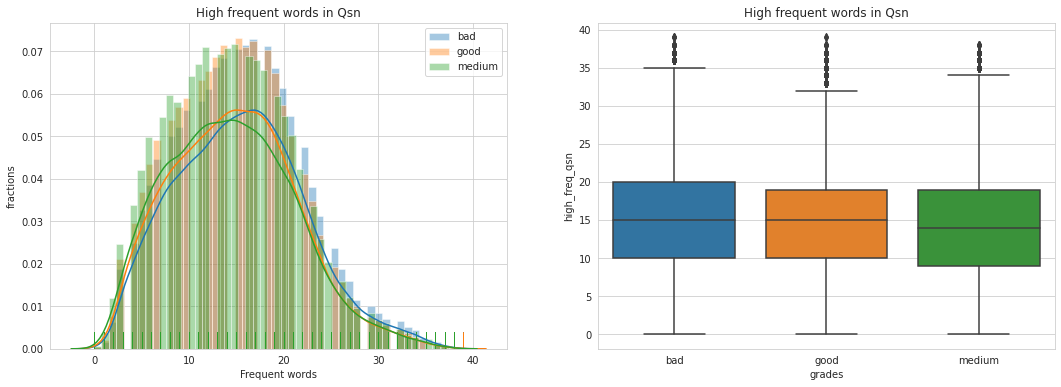

In [131]:
basic_statistics(['high_freq_qsn'])
plot_func(['high_freq_qsn'], "Frequent words", "fractions", "High frequent words in Qsn")

**Observations:**
1. Not much difference in stats for various category.
2. Plots are overlapping.
3. On average each sentence in question consists of 15 words from top 1000 frequent words.
4. Almost half of the words in a sent is only from 1000 words where the entire vocab size in 46,000+

+---------------+-------+-------+--------+
| high_freq_ans |  bad  |  good | medium |
+---------------+-------+-------+--------+
|    minimum    |   2   |   1   |   1    |
|    maximum    |   38  |   38  |   38   |
|      mean     | 20.61 | 16.76 | 16.35  |
|     median    |  21.0 |  17.0 |  17.0  |
|    25th per   |  17.0 |  13.0 |  11.0  |
|    50th per   |  21.0 |  17.0 |  17.0  |
|    75th per   |  24.0 |  20.0 |  22.0  |
|    90th per   |  28.0 |  23.0 |  25.0  |
|    95th per   |  31.0 |  24.0 |  27.0  |
|    99th per   |  35.0 |  28.0 |  32.0  |
+---------------+-------+-------+--------+


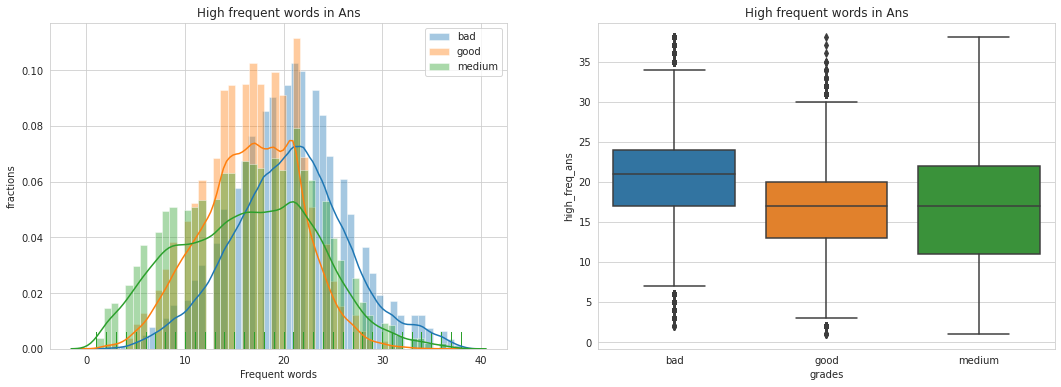

In [132]:
basic_statistics(['high_freq_ans'])
plot_func(['high_freq_ans'], "Frequent words", "fractions", "High frequent words in Ans")

**Observations:**
1. We can see different pattern for various category.
2. data with bad bleu score have lots of words from top 1000 words. On average it has 20.61 words which are extremly frequent.
3. Model is performing good when sentences are having around 16 frequent words.
4. IQR is narrow for good data than medium data.

+----------------+-------+-------+--------+
| high_freq_pred |  bad  |  good | medium |
+----------------+-------+-------+--------+
|    minimum     |   2   |   2   |   1    |
|    maximum     |   39  |   39  |   39   |
|      mean      | 21.83 | 22.47 | 20.62  |
|     median     |  22.0 |  22.0 |  21.0  |
|    25th per    |  18.0 |  19.0 |  17.0  |
|    50th per    |  22.0 |  22.0 |  21.0  |
|    75th per    |  26.0 |  25.0 |  24.0  |
|    90th per    |  30.0 |  29.0 |  28.0  |
|    95th per    |  32.0 |  31.0 |  31.0  |
|    99th per    |  36.0 |  35.0 |  35.0  |
+----------------+-------+-------+--------+


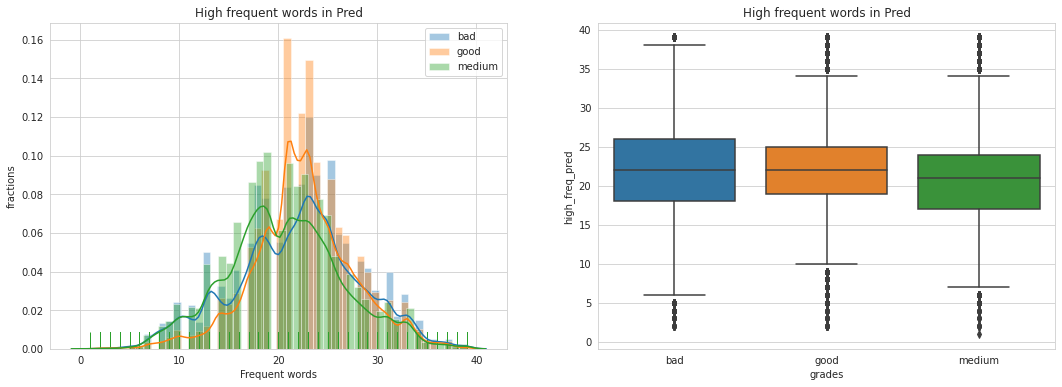

In [133]:
basic_statistics(['high_freq_pred'])
plot_func(['high_freq_pred'], "Frequent words", "fractions", "High frequent words in Pred")

**Observations:**
1. Prediction sentences are having lots of words from top 1000 words.
2. Model is performing better when there are 20 - 25 words are from frequent words.
3. As count of frequent decreases the performance is also becoming bad.

In [134]:
basic_statistics(['high_freq_qsn', 'high_freq_ans', 'high_freq_pred'], data=data[mask_bad])
basic_statistics(['high_freq_qsn', 'high_freq_ans', 'high_freq_pred'], data=data[mask_medium])
basic_statistics(['high_freq_qsn', 'high_freq_ans', 'high_freq_pred'], data=data[mask_good])

+----------+---------------+---------------+----------------+
|   bad    | high_freq_qsn | high_freq_ans | high_freq_pred |
+----------+---------------+---------------+----------------+
| minimum  |       0       |       2       |       2        |
| maximum  |       39      |       38      |       39       |
|   mean   |     15.47     |     20.61     |     21.83      |
|  median  |      15.0     |      21.0     |      22.0      |
| 25th per |      10.0     |      17.0     |      18.0      |
| 50th per |      15.0     |      21.0     |      22.0      |
| 75th per |      20.0     |      24.0     |      26.0      |
| 90th per |      24.0     |      28.0     |      30.0      |
| 95th per |      27.0     |      31.0     |      32.0      |
| 99th per |      33.0     |      35.0     |      36.0      |
+----------+---------------+---------------+----------------+
+----------+---------------+---------------+----------------+
|  medium  | high_freq_qsn | high_freq_ans | high_freq_pred |
+-------

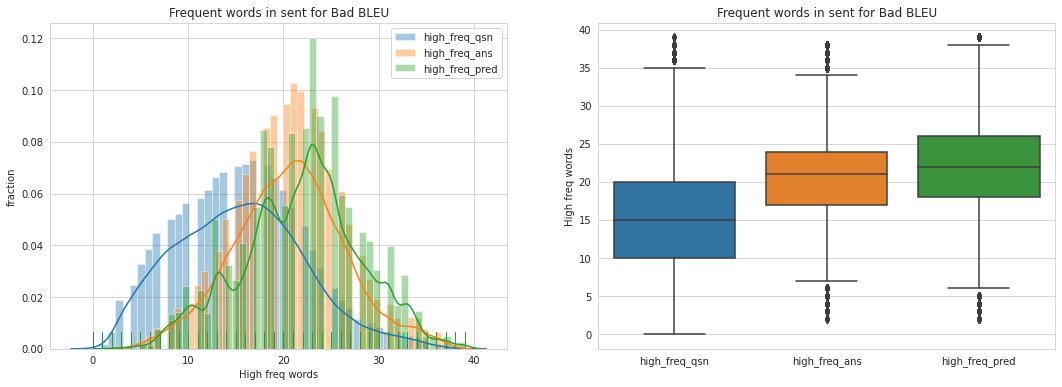

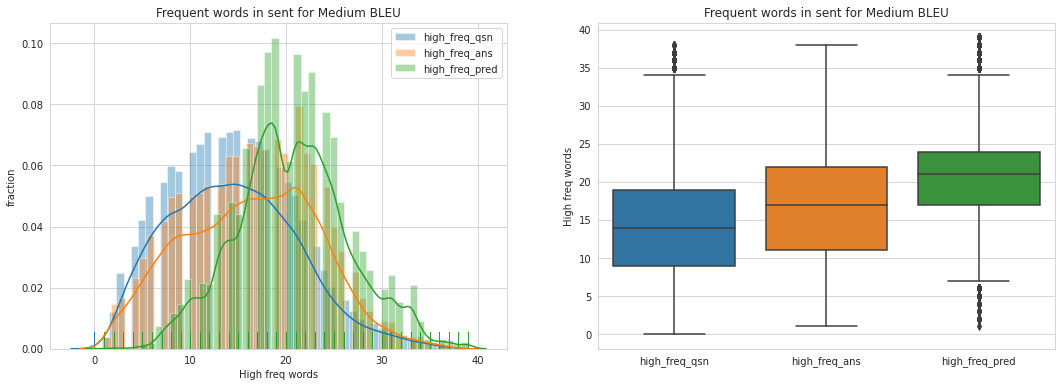

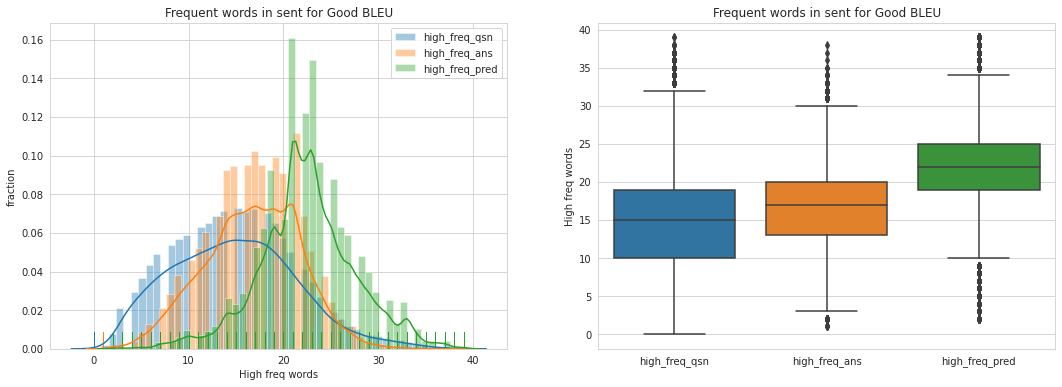

In [135]:
plot_func(['high_freq_qsn', 'high_freq_ans', 'high_freq_pred'], "High freq words", 'fraction', "Frequent words in sent for Bad BLEU", data=data[mask_bad])
plot_func(['high_freq_qsn', 'high_freq_ans', 'high_freq_pred'], "High freq words", 'fraction', "Frequent words in sent for Medium BLEU", data=data[mask_medium])
plot_func(['high_freq_qsn', 'high_freq_ans', 'high_freq_pred'], "High freq words", 'fraction', "Frequent words in sent for Good BLEU", data=data[mask_good])

**Observations:**
1. We can see that no of words from frequent words plays an important role in models performance.
2. Frequent words in question is not affecting grades much, but model is doing good for lesser frequent words in sentences.
3. No of frequent words in answer is very important, model is really doing well on sentences with small no of frequent words. It is giving best performance on answer with 13 - 20 frequent words, anything less grade is becoming medium and anything it is moving to bad.
4. Predictions are having lots of words from top 1000 bacause it is only predicting 15% words from answer vocab.

### Out of vocab words

In [136]:
def oov_word(column, toMatch, data):
    " Getting the count of words in a sentence which are not present in training data "
    counts = []
    toMatch = dict(toMatch)

    for sent in data[column].values:
        c = 0
        for word in sent.split():
            if not toMatch.get(word):
                c += 1
        counts.append(c)
        
    return counts

In [137]:
# Getting the oov counts
data['qsn_oov'] = oov_word('question', qsn_cnt, data)
data['ans_oov'] = oov_word('answer_out', ans_cnt, data)
data['pred_oov'] = oov_word('answer_pred', ans_cnt, data)

In [140]:
print("Ques:",data['qsn_oov'].unique())
print("Ans:",data['ans_oov'].unique())
print("Pred:",data['pred_oov'].unique())

Ques: [0 1 2 3 4]
Ans: [0 1 3 2 4]
Pred: [0]


In [142]:
basic_statistics(['qsn_oov'])
basic_statistics(['ans_oov'])

+----------+------+------+--------+
| qsn_oov  | bad  | good | medium |
+----------+------+------+--------+
| minimum  |  0   |  0   |   0    |
| maximum  |  4   |  4   |   4    |
|   mean   | 0.03 | 0.03 |  0.03  |
|  median  | 0.0  | 0.0  |  0.0   |
| 25th per | 0.0  | 0.0  |  0.0   |
| 50th per | 0.0  | 0.0  |  0.0   |
| 75th per | 0.0  | 0.0  |  0.0   |
| 90th per | 0.0  | 0.0  |  0.0   |
| 95th per | 0.0  | 0.0  |  0.0   |
| 99th per | 1.0  | 1.0  |  1.0   |
+----------+------+------+--------+
+----------+------+------+--------+
| ans_oov  | bad  | good | medium |
+----------+------+------+--------+
| minimum  |  0   |  0   |   0    |
| maximum  |  4   |  2   |   4    |
|   mean   | 0.01 | 0.01 |  0.02  |
|  median  | 0.0  | 0.0  |  0.0   |
| 25th per | 0.0  | 0.0  |  0.0   |
| 50th per | 0.0  | 0.0  |  0.0   |
| 75th per | 0.0  | 0.0  |  0.0   |
| 90th per | 0.0  | 0.0  |  0.0   |
| 95th per | 0.0  | 0.0  |  0.0   |
| 99th per | 1.0  | 1.0  |  1.0   |
+----------+------+------+--

#### Observation on oov words:
1. Checking the counts of out of vocab words in each sentences.
2. There are not many oov words in validation data. The mean is close to 0 with maximum 4 ov words in questions and 4 in bad and medium answers and 2 in good answers.
3. As we can see that there are not many oov words in out data because we have already taken large vocab with 46,000 words in training data question and 28,000 in answers.
4. According to lexicographer and dictionary expert Susie Dent, “the average active vocabulary of an adult English speaker is around 20,000 words, while his passive vocabulary is around 40,000 words.”

## Conclusion:
To conclude our EDA and explain the factors affecting model's performance, we have below details,
1. No of words in sentences of Answers are impacting the model. Model works good for smaller no of words in sent as count increases its performance is going down.
2. One of the main factor behind model's performance. With higher no of words in vocab both question and answer reducing its BLEU score. Vocab has 80% of rare words that model is not able to learn. And then 5% of frequent words which highly impactng the result.
3. Model is only able to predict 15% of words from entire answer vocab and then for all the words it is not able to predict replacing with high frequent words.
4. No of frequent words in answer when increases and frequent words in predicted sentences decreases then model is giving "bad" BLEU scores.